In [7]:
import numpy as np
import pandas as pd 
import datetime

# imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Import TFIDFVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

#tokenizers
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

#neural network RNN
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Working off of Tanveer's Clean Data 

In [4]:
# to load file 
daily = pd.read_csv('/Users/plarkin/Downloads/daily.csv')
daily.head()

,Unnamed: 0,date,text,price,pct_change,price_direction,day_of_week,is_holiday
0,0,2011-07-29,"Drug App Comes Free, Ads Included. Epocrates h...",1292.28,NaN,first,4,0
1,1,2011-07-30,Global Concern Over U.S. Debt Ceiling Disagree...,1292.28,0.000000,same,5,0
2,2,2011-07-31,"Deal May Avert Default, but Some Ask, ‘Is That...",1292.28,0.000000,same,6,0
3,3,2011-08-01,"Charging a Premium for Movies, at a Cost. High...",1286.94,-0.004132,down,0,0
4,4,2011-08-02,"Pearls, Finer but Still Cheap, Flow From China...",1254.05,-0.025557,down,1,0


## Sentiment Analysis

#### Vader Sentiment Analysis

#### Textblob Sentiment Analysis
source : https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair

https://textblob.readthedocs.io/en/dev/

In [5]:
#Adding in Sentiment analysis with designated columns for each output (pos, neg, neu, compound)
analyzer = SentimentIntensityAnalyzer()

#daily['vader'] = daily['text'].map(lambda x:analyzer.polarity_scores(str(x)))


daily['vader_compound'] = [analyzer.polarity_scores(x)['compound'] for x in daily['text']]
# draft_df['vd_neg'] = [analyzer.polarity_scores(x)['neg'] for x in draft_df['alltext']]
# draft_df['vd_neu'] = [analyzer.polarity_scores(x)['neu'] for x in draft_df['alltext']]
# draft_df['vd_pos'] = [analyzer.polarity_scores(x)['pos'] for x in draft_df['alltext']]

%time

from textblob import TextBlob
#testimonial = TextBlob()
#draft_df['tb_polarity'] = [testimonial.polarity(x)['polarity'] for x in draft_df['alltext']]
#draft_df['tb_subj'] = [testimonial.sentiment(x)['subjectivity'] for x in draft_df['alltext']]
daily['textblob_polarity'] = daily['text'].map(lambda words: TextBlob(str(words)).polarity) #polarity is more applicable and comparable to vader compound. subjectivity is more about opinion vs fact 

%time

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


### Text Cleaning
eliminate the punctuation, URL, and @
#source: https://monkeylearn.com/blog/text-cleaning/

In [6]:
#Use this to remove http, punctuation, URL, and @
daily['text'] = daily['text'].map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(x.lower())))
#convert price_direction to numerical and drop first row with NA value
daily.dropna(inplace=True)
daily['price_direction'] = daily['price_direction'].map({'down' : -1,'same' : 0 , 'up' : 1})

tokenize and lemmatize
(no longer lemmatizing, results from gridsearch showed superior accuracy without lemmatizing)

## RNN with TFIDF

In [14]:
#declaring features and target variable for tfidf. It will not take an array as the X input
the_text = daily['text']
the_target = daily['price_direction']

# TFIDF, increased to 5000 to capture more dates
rnn_tvec = TfidfVectorizer(stop_words='english', max_features = 5000, ngram_range= (1,2))
rnn_tvec_df = pd.DataFrame(rnn_tvec.fit_transform(the_text).todense(), columns=rnn_tvec.get_feature_names())


In [15]:
daily.head(1)

,Unnamed: 0,date,text,price,pct_change,price_direction,day_of_week,is_holiday,vader_compound,textblob_polarity
1,1,2011-07-30,global concern over us debt ceiling disagreeme...,1292.28,0.0,0,5,0,0.664,0.072709


In [16]:
rnn_tvec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Columns: 5000 entries, 10 to zuckerberg mark
dtypes: float64(5000)
memory usage: 139.3 MB


In [18]:
#merging vectorized dataframe with original dataset including sentiment analysis. More features!
merged_df = rnn_tvec_df.join(daily, how='inner',lsuffix= '_')
merged_df.head(2)


,10,10 billion,10 percent,100,100 million,11,12,12 billion,13,14,...,Unnamed: 0,date,text,price,pct_change,price_direction,day_of_week,is_holiday,vader_compound,textblob_polarity
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2011-07-30,global concern over us debt ceiling disagreeme...,1292.28,0.0,0,5,0,0.6640,0.072709
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2011-07-31,deal may avert default but some ask is that go...,1292.28,0.0,0,6,0,0.9962,0.094384


In [19]:
#setting date as index and dropping text column for modeling
merged_df.set_index('date', inplace=True)
merged_df.sort_index(inplace=True)

merged_df.drop(columns= ['text'], inplace=True)


### Train Test Split

In [27]:
X = merged_df.drop(columns= ['price_direction'])
y = merged_df[['price_direction']].values
yy = merged_df['price_direction']


In [28]:
yy.value_counts(normalize=True)

 1    0.380992
-1    0.311148
 0    0.307861
Name: price_direction, dtype: float64

In [26]:
#sticking with a test size of 0.20 to save 2 years of data to test on
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False, test_size=0.2)


In [29]:
# Scale for neural networks
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [30]:
# Create training sequences
train_sequences = TimeseriesGenerator(Xs_train, y_train, length=3, batch_size=64)
# Create test sequences
test_sequences = TimeseriesGenerator(Xs_test, y_test, length=3, batch_size=64)

In [31]:
train_sequences[0][0].shape

(64, 3, 5007)

In [32]:
input_shape = train_sequences[0][0][0].shape
input_shape

(3, 5007)

In [33]:
#modeling and layers
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences= True))
model.add(GRU(8, return_sequences= False))

model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='softmax'))

In [34]:
#compile it
model.compile(optimizer=Adam(learning_rate=.0005), loss='CategoricalCrossentropy', metrics=['acc'])


In [ ]:
#fit it
history = model.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)


In [ ]:
#plot our results
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();


In [ ]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend();

In [81]:
mb = MultinomialNB(alpha=1)
mb.fit(X_train, y_train)

mb.score(X_train, y_train), mb.score(X_test, y_test)

(0.7303082191780822, 0.5513698630136986)

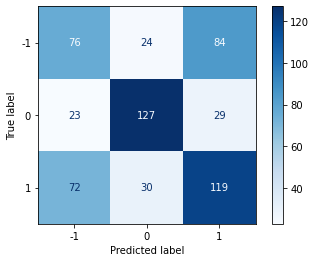

In [82]:
# predictions
preds = mb.predict(X_test)

# View confusion matrix
plot_confusion_matrix(mb, X_test, y_test, cmap='Blues');


In [84]:
accuracy_score(y_test, preds, sample_weight=None)
#aim for best accuracy, but also reduce false positives and negatives. 

0.5513698630136986

In [85]:
# calculate null accuracy (for multi-class classification problems)
# .head(1) assesses the value 1208
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy:', null_accuracy)

Null accuracy: 1    0.378425
Name: price_direction, dtype: float64


In [92]:
# print message text for the false negatives (spam incorrectly classified as ham)

fn= pd.DataFrame(X_test[preds < y_test])
fn['vader_compound']
# alternative less elegant but easier to understand
# X_test[(y_pred_class=0) & (y_test=1)]

KeyError: 'vader_compound'

# TODO" model best params with multinomial bayes, how accurate is it?

multinomial bayes non-lemmatized
knnclassifier? grid search

Try all out with open price

Try RNN

## Evaluation of Models

#### With lemmatization

TFIDF
{'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}
 
 {'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None,
 'tvec__sublinear_tf': True}
 
CVEC
 {'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}
 
accuracy score with TFIDF and multinomial bayes:  52.4%
accuracy score with CVEC and multinomial bayes: 44.2%
 
 
 
 
#### Non-lemmatized
 
 
 
 {'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None,
 'tvec__sublinear_tf': True}
accuracy score with TFIDF and multinomial bayes:  52.13%


{'nb__alpha': 1,
 'tvec__max_features': 1000,
 'tvec__ngram_range': (1, 1),
 'tvec__sublinear_tf': True}
 
accuracy score with TFIDF and multinomial bayes:  54.22%

{'nb__alpha': 1,
 'tvec__max_features': 1000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english',
 'tvec__sublinear_tf': True}
 accuracy score with TFIDF and multinomial bayes:  47.10%
 
 
 {'nb__alpha': 1,
 'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}
 
 accuracy score with TFIDF and multinomial bayes:  45.67%



models with sublinear_tf were removing/transforming the data of down days and altering predictions. those models will not be used.